In [714]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

REFERENCE: https://www.youtube.com/watch?v=TCH_1BHY58I

GOOGLE COLAB: https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing

In [715]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [716]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # alphabet
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# MAKEMORE 1

## Examples
Test with initial 5 words

In [137]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next one
X, Y = [], []  # X is input, Y is label
for w in words[:5]:
    print(w)
    context = [0] * block_size # initialize context by padding with 0
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop & append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [138]:
C = torch.randn((27,2)) # every 27 characters has 2 features embedded
C.shape

torch.Size([27, 2])

In [141]:
X.shape

torch.Size([32, 3])

In [142]:
emb = C[X]
emb.shape # 32 rows of input, each row has 3 char, each char is represented by 2 features

torch.Size([32, 3, 2])

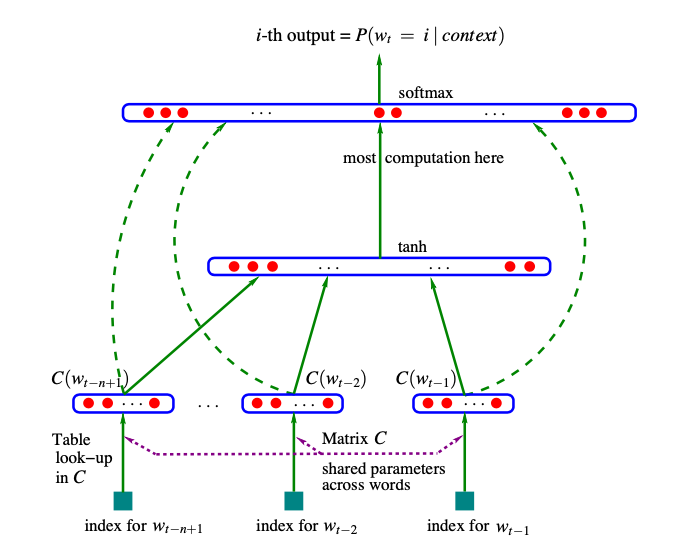

### Hidden Layer
tanh as activation function

In [143]:
# Construct the hidden layer
W1 = torch.randn((6, 100)) # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
b1 = torch.randn(100) # biases

In [144]:
W1.shape

torch.Size([6, 100])

- The idea is to perform `emb @ W1 + b1`
- However, `emb.shape` = `torch.Size([32, 3, 2])` and `W1.shape` = `torch.Size([6, 100])`, so unable to multiple
- Hence, `emb` needs to be re-shaped to `torch.Size([32, 6])` --> called

In [145]:
emb[:5]

tensor([[[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [-1.1304,  1.0066]],

        [[ 2.0425,  0.8423],
         [-1.1304,  1.0066],
         [ 1.3725, -1.2475]],

        [[-1.1304,  1.0066],
         [ 1.3725, -1.2475],
         [ 1.3725, -1.2475]],

        [[ 1.3725, -1.2475],
         [ 1.3725, -1.2475],
         [-0.0896,  0.5406]]])

In [146]:
# Method 1 to re-shape emb is to concatenate along the direction 1 (horizontally) 
# emb[:, 0, :] for the 1st char, emb[:, 1, :] for the 2nd char, and emb[:, 2, :] for the 3rd char
# basically convert 32 x 3 x 2 to 32 x (6) --> put 3x2 table into 1x6 table
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)[:3] # too specific, not able to generalize

tensor([[ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -1.1304,  1.0066],
        [ 2.0425,  0.8423, -1.1304,  1.0066,  1.3725, -1.2475]])

In [147]:
# Example of touch.unbind along the horizontal direction
torch.unbind(emb[4:7], 1)

(tensor([[ 1.3725, -1.2475],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]]),
 tensor([[ 1.3725, -1.2475],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]]),
 tensor([[-0.0896,  0.5406],
         [ 2.0425,  0.8423],
         [ 0.8501, -0.0449]]))

In [148]:
emb[4:7]

tensor([[[ 1.3725, -1.2475],
         [ 1.3725, -1.2475],
         [-0.0896,  0.5406]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 0.8501, -0.0449]]])

In [149]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)[:3] # too specific, not able to generalize

In [150]:
# torch.cat(torch.unbind(emb, dim=1), dim=1)[:3] # more generalized, but inefficient as it creates new tensor > new memory space

In [151]:
# Method 2 to re-shape emb by re-present to another shape using view() method
emb.view(32,6)

tensor([[ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -1.1304,  1.0066],
        [ 2.0425,  0.8423, -1.1304,  1.0066,  1.3725, -1.2475],
        [-1.1304,  1.0066,  1.3725, -1.2475,  1.3725, -1.2475],
        [ 1.3725, -1.2475,  1.3725, -1.2475, -0.0896,  0.5406],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  0.8501, -0.0449],
        [ 2.0425,  0.8423,  0.8501, -0.0449, -0.3361,  1.2816],
        [ 0.8501, -0.0449, -0.3361,  1.2816,  1.5350, -2.3814],
        [-0.3361,  1.2816,  1.5350, -2.3814,  0.8911, -1.9873],
        [ 1.5350, -2.3814,  0.8911, -1.9873,  1.5350, -2.3814],
        [ 0.8911, -1.9873,  1.5350, -2.3814, -0.0896,  0.5406],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -0.0896,  0.5406],
        [ 2.0425,  0.8423, -0.0896,  0.5406,  0.8911, -1.9873],
        [-0.0896,  0.5406,  0.8911, -1.9

In [152]:
emb.view(emb.shape[0],6) @ W1 + b1

tensor([[ 3.3140, -3.8671, -0.6250,  ..., -3.2905, -1.1911, -4.1697],
        [ 3.4037, -3.2638,  3.1368,  ..., -3.4133,  0.2480, -4.2026],
        [-4.1245, -8.0483,  0.6369,  ..., -3.0060, -1.2730,  3.5522],
        ...,
        [ 1.1871, -4.5686,  1.3899,  ..., -2.0376,  0.8434,  3.1872],
        [-0.2614, -1.4828, -1.3138,  ..., -1.3635, -2.7280,  2.9878],
        [10.1638,  0.1614,  0.9221,  ..., -2.0136,  2.5010, -1.6219]])

In [153]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) # inputs @ weights + bias, then apply activation function tanh
# use of tanh will keep all the outputs between -1 and 1

In [154]:
h

tensor([[ 0.9974, -0.9991, -0.5546,  ..., -0.9972, -0.8309, -0.9995],
        [ 0.9978, -0.9971,  0.9962,  ..., -0.9978,  0.2430, -0.9996],
        [-0.9995, -1.0000,  0.5628,  ..., -0.9951, -0.8546,  0.9984],
        ...,
        [ 0.8297, -0.9998,  0.8832,  ..., -0.9666,  0.6876,  0.9966],
        [-0.2556, -0.9020, -0.8652,  ..., -0.8772, -0.9915,  0.9949],
        [ 1.0000,  0.1600,  0.7269,  ..., -0.9650,  0.9866, -0.9249]])

### Final layer
softmax

In [155]:
# Construct the final layer
W2 = torch.randn((100, 27)) # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(27) # biases

- `Logits` are the outputs of a neural network before the activation function is applied. They are the unnormalized probabilities of the item belonging to a certain class.
- The `softmax function` is then applied to the logits to normalize them to sum to 1. This ensures that the probabilities of all classes add up to 1 and that the most likely class has the highest probability.

In [156]:
logits = h @ W2 + b2

In [157]:
logits.shape

torch.Size([32, 27])

In [158]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
prob.shape

torch.Size([32, 27])

In [159]:
# for each input element in X consisting of 3 chars, the probablity of 27 chars appear next is in prob
# to plug out the prob of char stored in Y (label), given the input X
prob[torch.arange(32),Y] # prob[0,Y[0]] === prob of input as X[0] and output as Y[0]

tensor([6.2005e-12, 1.9981e-03, 7.2258e-01, 1.3705e-05, 5.5161e-05, 8.0822e-13,
        1.7507e-01, 3.6645e-08, 7.7354e-08, 1.3147e-03, 1.1715e-09, 4.7185e-09,
        4.0241e-10, 5.8399e-03, 8.0691e-03, 5.1777e-11, 9.2270e-06, 5.8876e-10,
        3.1717e-07, 1.1788e-15, 3.5358e-07, 8.8870e-04, 9.1886e-04, 3.8306e-04,
        6.8576e-17, 4.6000e-14, 3.0683e-10, 4.2647e-11, 2.3882e-04, 1.8950e-13,
        7.5745e-07, 1.1082e-08])

In [160]:
# calculate loss function by negative log likelihood
loss = -prob[torch.arange(32),Y].log().mean().item()
loss

16.273956298828125

### Summary

In [161]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [162]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100)) # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
b1 = torch.randn(100) # biases
W2 = torch.randn((100, 27)) # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(27) # biases
parameters = [C, W1, b1, W2, b2]

In [163]:
sum(p.nelement() for p in parameters) # no. of parameters in total

3481

In [167]:
for p in parameters:
    p.requires_grad = True

In [170]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # similar to the above 3 codes. more efficient in both forward & backward pass
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

# currently overfitting of the first 32 examples with so many parameters --> easy to overfit

0.25524842739105225


## Full codes

In [717]:
BLOCK_SIZE = 3 # context length: how many chars do we take to predict the next one

In [718]:
# function to build data set with train/dev/test splits
def build_dataset(words):
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * BLOCK_SIZE # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X) # X contains indexes of input letters
    Y = torch.tensor(Y) # Y contains indexes of output letters
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [719]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

- `Logits` are the outputs of a neural network before the activation function is applied. They are the unnormalized probabilities of the item belonging to a certain class.
- The `softmax function` is then applied to the logits to normalize them to sum to 1. This ensures that the probabilities of all classes add up to 1 and that the most likely class has the highest probability.

In [720]:
# expected loss at initialization
-torch.tensor(1/27.0).log()

tensor(3.2958)

We need to make the loss at initialization around 3.29, by initializing smaller weights value at the output layer

### Build MLP

`Note` on `initial loss`:
- at initialization, we should have an expectation of the loss value, depending on the loss function and the problem
- in this problem, at initialization, we expect all characters to have equal probability i.e. `P(next_char) = 1/27.0`
- this means, the `logits` (before softmax) should be close to `0` --> equal probability for next character
- this can be achieved by reducing the `weights` value by `multiplying with a small factor 0.01` and set `biases` to `0`
- otherwise, by chance, the `logits` can take extreme values and cause the initial loss to be very high, not optimizing the initial values for neurons 
- addressing the over-confidence at the intialization

In [738]:
BLOCK_SIZE = 3 # context length: how many chars do we take to predict the next one
FEATURES = 10
NUM_NEURONS_W1 = 200 # number of neurons in hidden layer
vocab_size = 27

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,FEATURES),                      generator=g)        # features vector for 27 chars, each char has 10 features
W1 = torch.randn((BLOCK_SIZE*FEATURES, NUM_NEURONS_W1),     generator=g) * (5/3)/((BLOCK_SIZE*FEATURES)**0.5)  # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
# b1 = torch.randn(NUM_NEURONS_W1,                            generator=g) * 0    # biases
W2 = torch.randn((NUM_NEURONS_W1, vocab_size),              generator=g) * 0.01 # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(vocab_size,                                generator=g) * 0    # biases

# BatchNorm parameters
bngain = torch.ones((1, NUM_NEURONS_W1))                                        # batch normalization gain
bnbias = torch.zeros((1, NUM_NEURONS_W1))                                       # batch normalization bias
bnmean_running = torch.zeros((1, NUM_NEURONS_W1))
bnstd_running = torch.ones((1, NUM_NEURONS_W1))     

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # no. of parameters in total

# Set grad for parameters
for p in parameters:
    p.requires_grad = True

12097


In [739]:
x = torch.randn(27,30)
w = torch.randn(30, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.1073) tensor(0.9772)
tensor(0.0585) tensor(5.3708)


`Magic number` at initialization
- weights and biases are initialized using `torch.randn` (normal distribution) with `mean = 0` and `std = 1`
- the `magic numbers` used in initialization of the weights & biases `(W, b)` to scale the distribution of `input tensor @ W + b` to ensure its std is not expanded beyond 1. In other words, the output distribution is not too spread out over a wide range
- Otherwise, after `tanh` activation or other non-linear activation, distribution with large std will be squashed, resulting in dead neurons at initialization
- `Magic numbers = gain / sqrt(fan_in)` where `fan_in` = no. of inputs
- `gain` value varies with activation function (e.g., `tanh` is `5/3`, `ReLU` is `sqrt(2)`) - https://pytorch.org/docs/stable/nn.init.html

In [740]:
# lre = torch.linspace(-3,0,1000) # exponent
# lr = 10**lre # learning rate varies between 0.001 and 1
# lri = []

Batch normalization
- control the statistics of activation in the neural net
- usually affter linear layer
- at initialization, `hpre` should not be too small so `tanh` doesn't do anything, but not too large that `tanh` is saturated
- `hpre` should be `unit normal distribution`(zero mean and variance = 1)
- regularizing effects --> make it harder for the NN to overfit
- in this case, `b1` can be removed from adding to `hpre` as it is being normalized (subtracted by `bnmeani`). Its function is being replaced by `bnbias`. `b1.grad` is = 0

In [741]:
BATCH_SIZE = 32
max_steps = 200000
lossi = []
stepi = []

for i in range(max_steps):
    # mini batch construct - to save time
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, )) # pick only 32 samples from input X
    Xb, Yb = Xtr[ix], Ytr[ix]                       # batch X, Y

    # forward pass
    emb = C[Xb]                                     # embedding input characters to matrix C - each input is characterized by {FEATURES}
    embcat = emb.view(emb.shape[0], -1)             # concatenate the vectors
    # Linear (Weight) Layer
    hpre = embcat @ W1 # + b1                       # hidden layer pre-activation
    # BatchNorm Layer
    # ------------------------------------------------------------------
    bnmeani = hpre.mean(0, keepdim=True)
    bnstdi = hpre.std(0, keepdim=True)
    hpre = (hpre - bnmeani) / bnstdi                # standardize
    hpre = bngain * hpre + bnbias                   # scale and shift - to avoid forcing hpre to be Gaussian after initialization
    # --- Keep track of bnmean and bnstd --- #
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------------------------
    # Non-linear Activation
    h = torch.tanh(hpre)                            # hidden layer
    # Linear (Weight) layer - Output
    logits = h @ W2 + b2 
    # --- Loss function using softmax to get probability --- #
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # initial learning rate
    # lr_decay = 0.01 # after initial lr plataeu --> learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps/10) == 0 or i == max_steps-1: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i) 
     
     

      0/ 200000: 3.3101


  20000/ 200000: 2.6223
  40000/ 200000: 2.1457
  60000/ 200000: 1.8306
  80000/ 200000: 1.6999
 100000/ 200000: 2.2563
 120000/ 200000: 1.8168
 140000/ 200000: 2.3052
 160000/ 200000: 2.4364
 180000/ 200000: 1.8813
 199999/ 200000: 1.8689


`Note` on `saturated tanh` that causes `dead neurons`
- input to `tanh` function is squashed to values between -1 and 1 smoothly
- if too many output from `tanh` function is near -1 and 1 --> its local `grad` is 0 --> back propagation is destroyed via chain rule (multiplication)
- similar issue with `sigmoid` and `ReLU` at the squashing region (flat region)
- this can stack up with more layers of neurons
- `grad` that passes through `tanh` (through chain rule) is only gonna get squashed, by the factor of `(1-t**2)` depending on how far you are from the tails

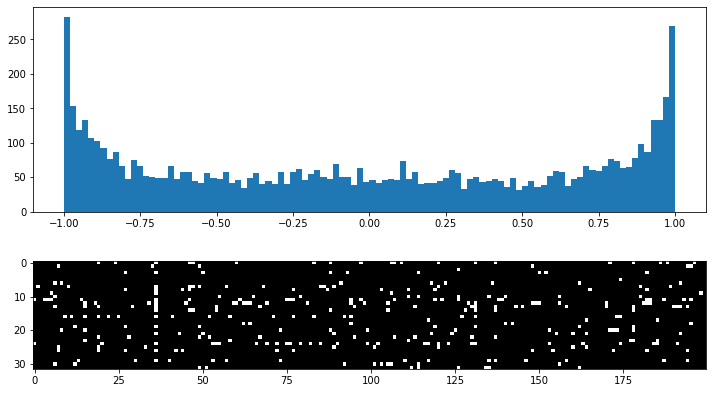

In [742]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].hist(h.view(-1).tolist(),100); # example of fewer values at extreme -1 and 1
ax[1].imshow(h.abs()>0.99, cmap='gray', interpolation='nearest') # white = True, black = False

# if there is a column of full white --> dead neuron as it is not activated
# tanh = -1 or 1 --> .backward() = (1-t**2) = 0 --> backward propagation is destroyed --> the neuron never learns

fig.tight_layout()

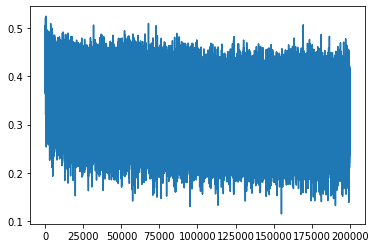

In [743]:
plt.plot(stepi, lossi) # log scale
# the fuzziness in lossi at the bottom of the graph is because we are training on the minibatches with small batch size --> can consider increase

In [627]:
# plt.plot(lre, losses) # best learning rate is at the minimum i.e., lr = 10**(-1) = 0.1

In [744]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpre = embcat @ W1 + b1
    hpre = bngain * (hpre - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpre) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0669515132904053
val 2.1065783500671387


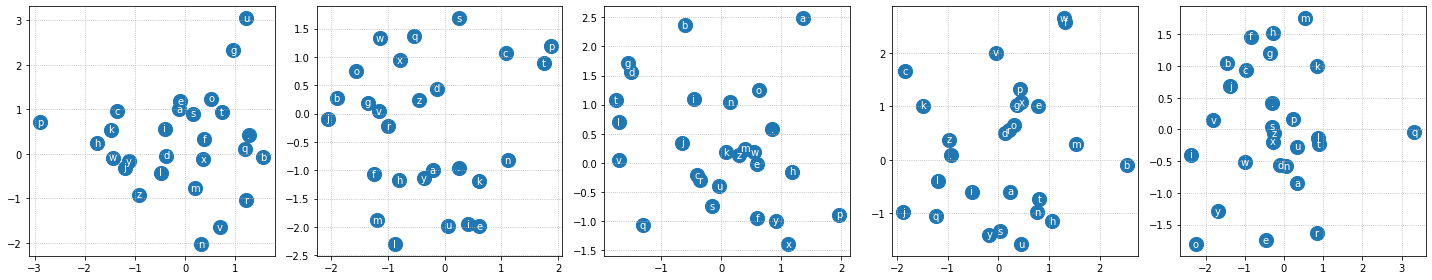

In [746]:
# visualize every 2 dimensions of the embedding matrix C for all characters
ROW_NUM = 1
COL_NUM = int(C.shape[1]/2)
fig, ax = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,4))
i = 0
for i in range(COL_NUM):
    ax[i].scatter(C[:,i*2].data, C[:,i*2+1].data, s = 200)
    for j in range(C.shape[0]):
        ax[i].text(C[j,i*2].item(), C[j,i*2+1].item(), itos[j], ha='center', va='center', color='white')
    ax[i].grid(linestyle = ':')

fig.tight_layout()

`Comments` on above graph:
- the NN learns to characterize the letters on a 2-D vector space (using 2 parameters to characterize/embed each char)
- the closer the letters are, the more similar they are, based on the learning of NN
- e.g., the vowels are quite close together (a, e, i, o, u)
- e.g., q is quite far away from the rest

`Note`:
- training split, dev/validation split, testing split: 80% (optimize parameters), 10% (hyperparameter tuning), 10% (evaluate the model at the very end)
- train loss and dev loss is about equal --> not overfitting but underfitting
- underfitting typically means that our network is very tiny, and we expect to improve the performance by scaling up the size of the NN
- if changing the learning rate doesn't improve the loss, consider:
- --> Increase no. of neurons
- --> Increase the no. of features for embedding the characters

### Sampling from model

In [745]:

g = torch.Generator().manual_seed(214748364)
for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE # current context window size = 3
    while True:
        emb = C[torch.tensor([context])] # initialize with ...
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpre = embcat @ W1
        hpre = (hpre - bnmean_running) / bnstd_running # standardize
        hpre = bngain * hpre + bnbias # scale and shift - to avoid forcing hpre to be Gaussian after initialization
        h = torch.tanh(hpre)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # shift the context window
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

braiton.
hell.
kamorceh.
demollya.
jemaraj.
marah.
den.
yshodan.
nakelly.
delyn.
kie.
xela.
elonien.
seannie.
rolvory.
kosian.
aruw.
esten.
berias.
tri.


# MAKEMORE 2
- Pytorch-ify the code
- Multi layer neuron network
- Include Batch Normarlization layer
- Diagnosit tools

In [872]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5 # Gaussian (normal) distribution
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [873]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with back propagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wtih a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)              # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [874]:
block_size = 4

In [875]:
# function to build data set with train/dev/test splits
def build_dataset(words):
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * block_size # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X) # X contains indexes of input letters
    Y = torch.tensor(Y) # Y contains indexes of output letters
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [876]:
n_embd = 10                                         # the dimensionality of the character embedding vectors
n_hidden = 100                                      # the no. of neurons in the hidden layer of the MLP
vocab_size = 27
g = torch.Generator().manual_seed(2147483657)       # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(fan_in=(n_embd * block_size), fan_out=n_hidden),     BatchNorm1d(n_hidden),      Tanh(),
    Linear(fan_in=n_hidden,              fan_out=n_hidden),     BatchNorm1d(n_hidden),      Tanh(),
    Linear(fan_in=n_hidden,              fan_out=n_hidden),     BatchNorm1d(n_hidden),      Tanh(),
    Linear(fan_in=n_hidden,              fan_out=n_hidden),     BatchNorm1d(n_hidden),      Tanh(),
    Linear(fan_in=n_hidden,              fan_out=n_hidden),     BatchNorm1d(n_hidden),      Tanh(),
    Linear(fan_in=n_hidden,              fan_out=vocab_size),   BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less conffident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # weight equivalent on batchNorm layer
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3                  # gain value for Tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))         # no. of parameters in total

for p in parameters:
    p.requires_grad = True

48551


`Batch normalization` is usually placed before `non-linear layer` and after `linear layer`

`Gain` for `Tanh`:
- `Tanh` function, by design, is a squashing function. It takes the distribution and slightly squashed it.
- `Gain` is necessary to prevent `Tanh` from squashing too much & keep expanding the distribution


`Why` the use of non-linear layer (e.g., `Tanh`):
- if there are only multiple linear layers, then it essentially just a single linear transformation
- The squash function (nonlinearity) is crucial for the success of neural networks!
- Without the squash function, the multilayer feedforward network would behave like a single layer feedforward network!
- By adding non-linear layer, any neural network can virtually represent any types of functions

In [878]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Stochastic gradient descent
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps/10) == 0 or i == max_steps-1: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) #log10 is nice visualization - looking at the exponent

    # if i == 1000:
    #     break # AFTER_DEBUG: would take out to run full optimization

      0/ 200000: 3.2828
  20000/ 200000: 2.1293
  40000/ 200000: 2.4472
  60000/ 200000: 1.9138
  80000/ 200000: 2.3761
 100000/ 200000: 1.4946
 120000/ 200000: 1.8870
 140000/ 200000: 2.3211
 160000/ 200000: 2.3043
 180000/ 200000: 1.9531
 199999/ 200000: 2.2998


### Diagnostics

 layer 0 (    Linear): mean -0.27, std 2.51
 layer 3 (    Linear): mean +0.05, std 2.21
 layer 6 (    Linear): mean +0.01, std 2.24
 layer 9 (    Linear): mean -0.00, std 2.23
 layer 12 (    Linear): mean +0.10, std 2.29
 layer 15 (    Linear): mean -0.02, std 4.34


Text(0.5, 1.0, 'Linear layer distribution')

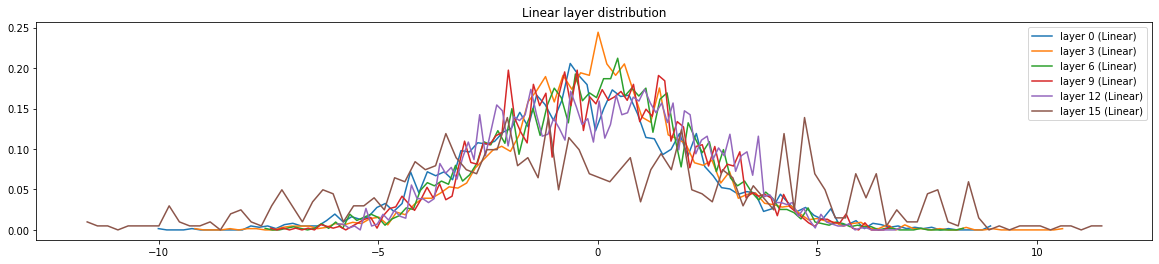

In [879]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(' layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Linear layer distribution')

#### Non-linear layer output
- Look out for saturation level (histogram) at `-1` and `1`, where the gradient is 0 and the neurons are not learning (a.k.a `dead neurons`)

 layer 2 (      Tanh): mean -0.00, std 0.69, saturated: 15.59%
 layer 5 (      Tanh): mean +0.01, std 0.72, saturated: 16.62%
 layer 8 (      Tanh): mean +0.02, std 0.75, saturated: 17.59%
 layer 11 (      Tanh): mean -0.01, std 0.76, saturated: 18.25%
 layer 14 (      Tanh): mean +0.02, std 0.78, saturated: 19.53%


Text(0.5, 1.0, 'Activation distribution')

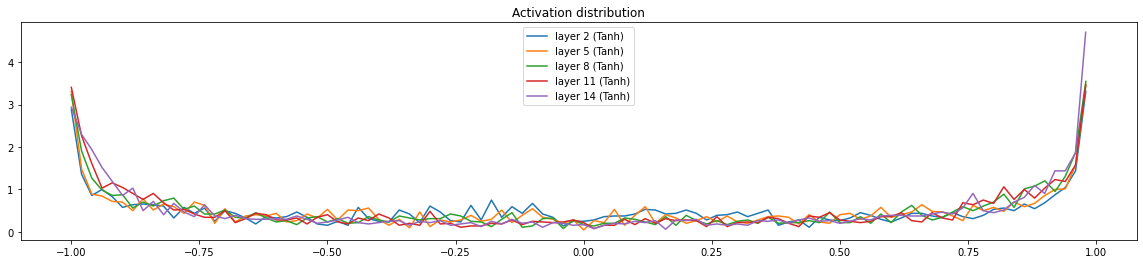

In [880]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(' layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

#### Non-linear layer gradient

 layer 2 (      Tanh): mean -0.00, std 0.00
 layer 5 (      Tanh): mean +0.00, std 0.00
 layer 8 (      Tanh): mean +0.00, std 0.00
 layer 11 (      Tanh): mean +0.00, std 0.00
 layer 14 (      Tanh): mean -0.00, std 0.00


Text(0.5, 1.0, 'Gradient distribution')

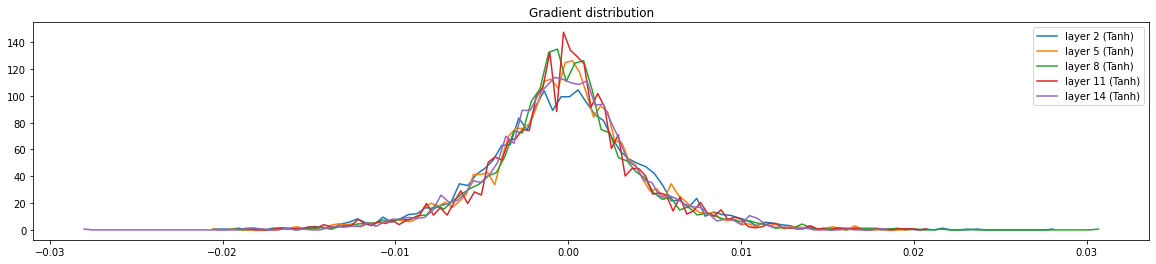

In [881]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(' layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

`grad:data ratio` should not be too large. 
- This is because when we update the `data` at each iteration, we multiply the `learning rate` with `p.grad`. If `grad` is too big as compared to `data`, it is difficult to train the NN
- What is probably more important is the `update:data ratio`, which shows how data actually changes

#### Weights' gradient

weight   (27, 10) | mean +0.000000 | std 1.972226e-02 | grad:data ratio 1.756584e-02
weight  (40, 100) | mean +0.000290 | std 9.777674e-03 | grad:data ratio 2.560972e-02
weight (100, 100) | mean +0.000069 | std 6.881999e-03 | grad:data ratio 2.668167e-02
weight (100, 100) | mean +0.000004 | std 6.803758e-03 | grad:data ratio 2.702831e-02
weight (100, 100) | mean +0.000081 | std 6.363077e-03 | grad:data ratio 2.610132e-02
weight (100, 100) | mean +0.000167 | std 6.101188e-03 | grad:data ratio 2.612331e-02
weight  (100, 27) | mean -0.000232 | std 9.977967e-03 | grad:data ratio 2.954203e-02


Text(0.5, 1.0, 'weights gradient distribution')

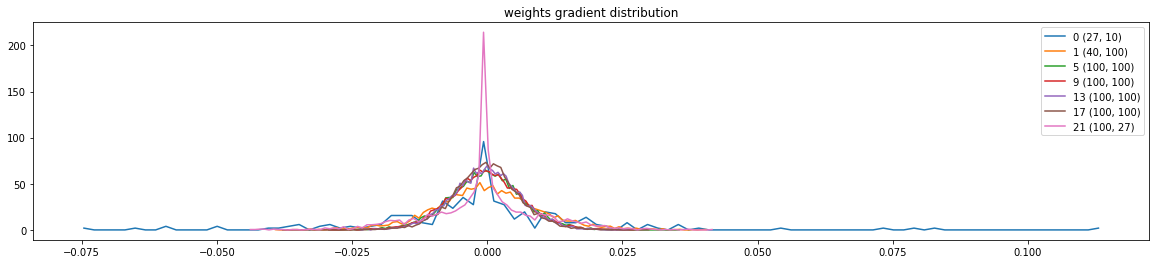

In [882]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

#### Update:data ratio
- to identify if the learning rate (aka `lr*p.grad.std() / p.data.std()).log10()`) is too fast or too slow
- `-3` in log scale is generally good. Should not be too low (slow learning) or too high (fast learning)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


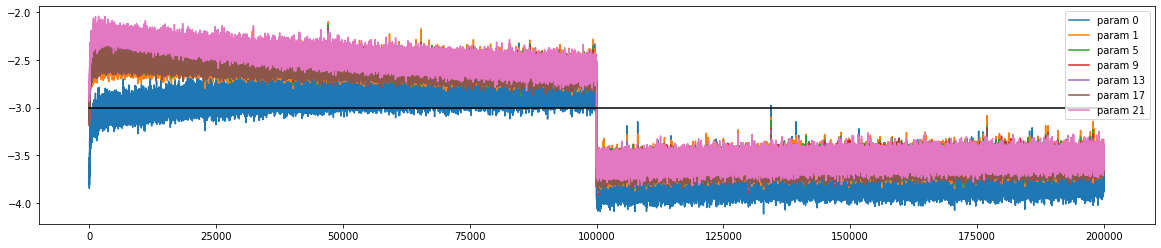

In [883]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these rations should be ~ 1e-3, indicated on plot
plt.legend(legends)

In [884]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.9134403467178345
val 2.028092384338379


In [885]:
# sample from the model
g = torch.Generator().manual_seed(2147473647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # current context window size = 3
    while True:
        emb = C[torch.tensor([context])] # initialize with ...
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # shift the context window
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

derriana.
fynnie.
zaeden.
pinn.
marlos.
anist.
nona.
moriel.
zachib.
lucistobia.
devan.
lilliano.
aryannaron.
reigh.
sama.
mai.
kalayah.
eareia.
daley.
jhorron.
